**Lab details:**

Natural language Processing (NLP) - CS429
Lab Session-4
Date- 09/09/2025
Marks - 10

**Instruction:**
1) The name of your Python file must follow this format: **studentID_Name**
   - Example: If Student ID = 2022B3A70617P and Name = Nikhil Manvendra Singh
   - File name should be: 2022B3A70617P_Nikhil_Manvendra_Singh.ipynb
2) Submission Deadline: 6:15 PM (Today)
3) Students are required to fill the blanks with code syntax in the section provided below and Attempt evaluative question

This labsheet introduces the basics of the Word2Vec model and its application in Natural Language Processing (NLP). In NLP, representing words in a way that preserves their meaning is a crucial step. Traditional approaches such as Bag of Words or TF–IDF only count how often words occur, without considering the context in which they appear. These methods create large and sparse representations, and they fail to capture the relationships between words.

**--------------------------------------------------------------------------Theory Section------------------------------------------------------------------------------------**

**Word2Vec :**

- Word2Vec is a method to turn words into numbers (vectors) so that computers can understand meaning. 
- Instead of treating words as separate symbols, it represents them in a way that captures their relationships.
- Words that appear in similar contexts have similar vectors.
- Example: “king” – “man” + “woman” ≈ “queen”.

**How it works:**

- Word2Vec learns from text using a neural network with two main approaches: CBOW and Skip-Gram
- **CBOW (Continuous Bag of Words):** Predicts the target word from surrounding context words.
  - Example: “The cat ___ on the mat” → predicts sits.
- **Skip-Gram:** Predicts surrounding words from a target word.
  - Example: Given cat, predicts nearby words like pet, animal, mat.

**Why it’s useful:**
- Finds similarity between words (dog is close to puppy).
- Groups related words together (Paris ↔ France, Tokyo ↔ Japan).
- Useful in NLP tasks like translation, sentiment analysis, chatbots, etc.

**Why Word2Vec is Better than Previous Embeddings**

**1) Captures Meaning (Semantics)**
- BoW & TF–IDF only count words → they don’t know that dog and puppy are related.
- Word2Vec places similar words close together in vector space.

**2) Considers Context**
- In Word2Vec, the meaning of a word depends on its neighbors.
- Example: “bank” in river bank vs money bank → different contexts.

**3) Considers Context**
- In Word2Vec, the meaning of a word depends on its neighbors.
- Example: “bank” in river bank vs money bank → different contexts.

**4) Dense Representation**
- BoW/TF–IDF create sparse, huge vectors (mostly zeros).
- Word2Vec creates small, dense vectors (like 100–300 dimensions).

**5) Learns Relationships**
- Arithmetic on vectors is meaningful:
 - king – man + woman ≈ queen.
- Previous methods can’t do this.

**6) Efficient & Scalable**
- Word2Vec is faster and works well with large text data.
- TF–IDF grows too large as vocabulary increases.

**7) Generalization**
- Word2Vec generalizes better → words not seen often can still be understood by similarity.
- TF–IDF gives almost no info for rare words.

**Research Paper associated with Word2Vec:**  /https://arxiv.org/pdf/1411.2738

**Implementing Word2Vec with Skip-Gram and Negative Sampling:**

In this lab, we will implement the Word2Vec model using the Skip-Gram with Negative Sampling technique. For the implementation, please refer to the attached PDF, Section 5.5 titled Word2Vec (pages 10–16).

**--------------------------------------------------------------------------Implementation Section------------------------------------------------------------------------------------**

### Import libraries

In [5]:
import math
import random
from collections import Counter
from itertools import chain
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [6]:
tiny_corpus = [
    "I like to eat apricot jam on toast",
    "The jar of apricot jam is on the table",
    "She spread jam on the bread",
    "He likes fruit jam and bread",
    "We bought a jar of strawberry jam",
    "Apricot is a sweet fruit",
    "They enjoy toast with strawberry jam in the morning",
    "The bread was fresh and warm from the oven",
    "I like to drink fresh orange juice with breakfast",
    "Banana is a healthy fruit full of energy",
    "We shared apple pie and strawberry ice cream",
    "The farmer grows apricots, plums, and grapes",
    "He spread butter and jam on the toast",
    "Children love sweet jam sandwiches",
    "She bought fresh strawberries from the market",
    "Grapes and apples are kept in the wooden basket",
    "We made fresh fruit salad with banana and orange",
    "The table was full of bread, jam, and cheese",
    "He baked a loaf of bread with raisins and nuts",
    "They made jam from apricots and strawberries",
    "Orange marmalade tastes good on toast"
]

print("Corpus size:", len(tiny_corpus))
print("First sentence:", tiny_corpus[0])

Corpus size: 21
First sentence: I like to eat apricot jam on toast


### Tokenize Corpus      [1M]

In [7]:
# Define a function to tokenize the corpus
def tokenize_corpus(corpus):
    tokenized = [sentence.lower().split() for  sentence in corpus]    # convert each sentence to lowercase and split into words
    return tokenized   # return the tokenized list

# Apply the tokenizer on our tiny corpus
tokenized = tokenize_corpus(tiny_corpus)

# Print first 2 tokenized sentences to verify
print("Tokenized corpus:", tokenized[:2])   # check first 2 sentences



Tokenized corpus: [['i', 'like', 'to', 'eat', 'apricot', 'jam', 'on', 'toast'], ['the', 'jar', 'of', 'apricot', 'jam', 'is', 'on', 'the', 'table']]


### Build Vocabulary      [1M]

In [8]:
# Function to build vocabulary from tokenized sentences
def build_vocab(tokenized, min_count=1):
    cnt = Counter(word for sentence in tokenized for word in sentence)    # count all words in the tokenized corpus
    vocab = {w: i for i, (w, c) in enumerate(cnt.items()) if c>=min_count}   # keep words above threshold
    idx2word = [w for w, c in cnt.items() if c >= min_count]                   # list of words
    word_counts = np.array([cnt[w] for w in idx2word], dtype=np.float64)        # word frequencies
    return vocab, idx2word, word_counts

# Build vocab from our tokenized corpus
vocab, idx2word, word_counts = build_vocab(tokenized)

# Print some checks
print("Vocab size:", len(vocab))
print("First 10 vocab entries:", list(vocab.items())[:10])
print("Word counts:", word_counts[:10])


Vocab size: 77
First 10 vocab entries: [('i', 0), ('like', 1), ('to', 2), ('eat', 3), ('apricot', 4), ('jam', 5), ('on', 6), ('toast', 7), ('the', 8), ('jar', 9)]
Word counts: [ 2.  2.  2.  1.  3.  9.  5.  4. 11.  2.]


### Generate Positive (target, context) Pairs     [1M]

In [9]:
# Function to generate positive (target, context) pairs using a sliding window
def generate_pos_pairs(tokenized, vocab, window=2):
    pairs = []
    for sent in tokenized:
        indices = [vocab[w] for w in sent if w in vocab]          # convert words to indices
        for i, target in enumerate(indices):
            start = max(0, i - window)
            end   = min(len(indices), i + window + 1)
            for j in range(start, end):
                if j == i:
                    continue
                context = indices[j]             # get context index
                pairs.append((target, context))                   # save (target, context) pair
    return pairs

# Generate pairs
pairs = generate_pos_pairs(tokenized, vocab, window=2)

# Print some checks
print("Number of pairs:", len(pairs))
print("First 10 pairs (as indices):", pairs[:10])
print("First 10 pairs (as words):", [(idx2word[w], idx2word[c]) for w, c in pairs[:10]])



Number of pairs: 518
First 10 pairs (as indices): [(0, 1), (0, 2), (1, 0), (1, 2), (1, 3), (2, 0), (2, 1), (2, 3), (2, 4), (3, 1)]
First 10 pairs (as words): [('i', 'like'), ('i', 'to'), ('like', 'i'), ('like', 'to'), ('like', 'eat'), ('to', 'i'), ('to', 'like'), ('to', 'eat'), ('to', 'apricot'), ('eat', 'like')]


### Dataset with Negative Sampling     [1M]

In [10]:
import torch
from torch.utils.data import Dataset
import numpy as np

class SGNSDataset(Dataset):
    def __init__(self, pairs, word_counts, idx2word, neg_k=5, alpha=0.75):
        self.pairs = pairs
        self.word_counts = word_counts
        self.neg_k = neg_k
        self.vocab_size = len(word_counts)
        probs = word_counts ** alpha                 # raise counts to alpha
        self.neg_probs = probs / probs.sum()         # normalize into probabilities
        self.idx2word = idx2word

    def __len__(self):
        return len(self.pairs)                        # total number of pairs

    def __getitem__(self, i):
        w, c = self.pairs[i]                         # target, context
        negs = np.random.choice(self.vocab_size, size=self.neg_k, p=self.neg_probs)  # negative samples
        return (
            torch.tensor(w, dtype=torch.long),
            torch.tensor(c, dtype=torch.long),
            torch.tensor(negs, dtype=torch.long)
        )

# Create dataset instance
dataset = SGNSDataset(pairs, word_counts, idx2word, neg_k=3)

# Print checks
print("Dataset length:", len(dataset))
print("Example item (target, context, negatives):", dataset[0])
print("As words:", idx2word[dataset[0][0]], idx2word[dataset[0][1]], [idx2word[n] for n in dataset[0][2]])


Dataset length: 518
Example item (target, context, negatives): (tensor(0), tensor(1), tensor([76,  5, 16]))
As words: i like ['table', 'fresh', 'bread']


### Define Skip-gram with Negative Sampling (SGNS) Model                      [1 M]

In [11]:
# Define the SGNS (Skip-Gram with Negative Sampling) model
class SGNSModel(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        self.in_embed  = nn.Embedding(vocab_size, emb_dim)   # Input embedding matrix (W)
        self.out_embed = nn.Embedding(vocab_size, emb_dim)   # Output embedding matrix (C)
        self._init_weights()

    def _init_weights(self):
        init_range = 0.5 / self.in_embed.embedding_dim
        nn.init.uniform_(self.in_embed.weight, -init_range, init_range)   # initialize input embeddings
        nn.init.uniform_(self.out_embed.weight, -init_range, init_range)  # initialize output embeddings

    def forward(self, target_idx, pos_idx, neg_idx):
        """
        target_idx: (B,)  → target word indices
        pos_idx:   (B,)  → positive context word indices
        neg_idx:   (B,k) → negative sample word indices
        returns: loss for the batch (scalar)
        """
        v_t   = self.in_embed(target_idx)             # (B, d) → target embeddings
        v_pos = self.out_embed(pos_idx)               # (B, d) → positive context embeddings
        v_neg = self.out_embed(neg_idx)               # (B, k, d) → negative embeddings

        # Positive score: dot product of v_t and v_pos
        pos_score = torch.sum(v_t*v_pos, dim=1)   # (B,)

        # Negative scores: dot product of v_t and v_neg
        neg_score = torch.bmm(v_neg, v_t.unsqueeze(2)).squeeze(2)    # (B, k)

        # Loss function: -[ logσ(pos_score) + sum logσ(-neg_score) ]
        pos_loss = F.logsigmoid(pos_score)                           # (B,)
        neg_loss = torch.sum(F.logsigmoid(-neg_score), dim=1)        # (B,)
        loss = - (pos_loss + neg_loss).mean()
        return loss

    def get_input_embeddings(self):
        return self.in_embed.weight.data.cpu().numpy()



In [12]:
model = SGNSModel(vocab_size=len(vocab), emb_dim=50)  # Create model instance
sample = dataset[0]  # Take one sample from dataset
print("Sample:", sample)
print("As words:", idx2word[sample[0]], idx2word[sample[1]], [idx2word[n] for n in sample[2]])

Sample: (tensor(0), tensor(1), tensor([28, 41, 52]))
As words: i like ['in', 'full', 'grapes']


### Training function (returns loss history)              [3M]

**train_skipgram():**
- Trains a model on corpus and returns the learned embeddings, vocabulary, model, and training history.

In [13]:
def train_skipgram(corpus, emb_dim=100, window=2, neg_k=5, min_count=1,
                   batch_size=512, epochs=5, lr=0.025, log_every=100):
    # 1) Preprocess
    tokenized = tokenize_corpus(corpus)                                      # tokenize the corpus
    vocab, idx2word, word_counts = build_vocab(tokenized, min_count=min_count)  # build vocab
    pairs = generate_pos_pairs(tokenized, vocab, window=window)              # positive pairs
    print(f"[train_skipgram] Vocab size: {len(idx2word)}, training pairs: {len(pairs)}")

    # 2) Dataset & DataLoader
    dataset = SGNSDataset(pairs, word_counts, idx2word, neg_k=neg_k)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)

    # 3) Model & optimizer (CPU)
    model = SGNSModel(len(idx2word), emb_dim)   # create model
    opt = torch.optim.SGD(model.parameters(), lr=lr)

    # 4) Training loop
    batch_losses, epoch_losses = [], []
    for epoch in range(1, epochs+1):
        total_loss, n_batches = 0.0, 0
        print(f"\nStarting epoch {epoch}/{epochs} ...")

        for batch_idx, batch in enumerate(dataloader, start=1):
            tgt, pos, negs = batch   # tensors from dataset

            # forward + backward + step
            opt.zero_grad()              # clear gradients
            loss = model(tgt, pos, negs) # compute loss
            loss.backward()              # backprop
            opt.step()                   # update parameters

            # bookkeeping
            loss_item = loss.item()      # float value of loss
            batch_losses.append(loss_item)
            total_loss += loss_item
            n_batches += 1

            if batch_idx % log_every == 0:
                print(f"  [Epoch {epoch}] Batch {batch_idx} | Batch loss: {loss_item:.4f} | Avg loss: {total_loss/n_batches:.4f}")

        # end of epoch
        epoch_avg = total_loss / max(1, n_batches)
        epoch_losses.append(epoch_avg)
        print(f"Epoch {epoch} finished — avg loss: {epoch_avg:.4f}")

    # 5) Return results
    embeddings = model.get_input_embeddings()   # get numpy embeddings
    history = {"batch_losses": batch_losses, "epoch_losses": epoch_losses}
    return embeddings, vocab, idx2word, model, history

In [14]:
# Block 6 — Run training
emb, vocab, idx2word, model, history = train_skipgram( tiny_corpus,  emb_dim=50,  window=2, neg_k=5, min_count=1, batch_size=8, epochs=50, lr=0.05)


[train_skipgram] Vocab size: 77, training pairs: 518

Starting epoch 1/50 ...
Epoch 1 finished — avg loss: 4.1589

Starting epoch 2/50 ...
Epoch 2 finished — avg loss: 4.1588

Starting epoch 3/50 ...
Epoch 3 finished — avg loss: 4.1588

Starting epoch 4/50 ...
Epoch 4 finished — avg loss: 4.1588

Starting epoch 5/50 ...
Epoch 5 finished — avg loss: 4.1588

Starting epoch 6/50 ...
Epoch 6 finished — avg loss: 4.1587

Starting epoch 7/50 ...
Epoch 7 finished — avg loss: 4.1587

Starting epoch 8/50 ...
Epoch 8 finished — avg loss: 4.1586

Starting epoch 9/50 ...
Epoch 9 finished — avg loss: 4.1585

Starting epoch 10/50 ...
Epoch 10 finished — avg loss: 4.1584

Starting epoch 11/50 ...
Epoch 11 finished — avg loss: 4.1582

Starting epoch 12/50 ...
Epoch 12 finished — avg loss: 4.1580

Starting epoch 13/50 ...
Epoch 13 finished — avg loss: 4.1578

Starting epoch 14/50 ...
Epoch 14 finished — avg loss: 4.1574

Starting epoch 15/50 ...
Epoch 15 finished — avg loss: 4.1571

Starting epoch 16/5

### Save the Model

In [15]:
# Save embeddings text
out_file = "sgns_embeddings.txt"
with open(out_file, "w", encoding="utf8") as f:
    V, D = emb.shape
    f.write(f"{V} {D}\n")
    for i, w in enumerate(idx2word):
        vec = " ".join(map(str, emb[i].tolist()))
        f.write(f"{w} {vec}\n")
print("Saved embeddings to", out_file)

# Save PyTorch model weights
torch.save(model.state_dict(), "sgns_model_weights.pth")
print("Saved model weights to sgns_model_weights.pth")

Saved embeddings to sgns_embeddings.txt
Saved model weights to sgns_model_weights.pth


### Plot loss & inspect embeddings

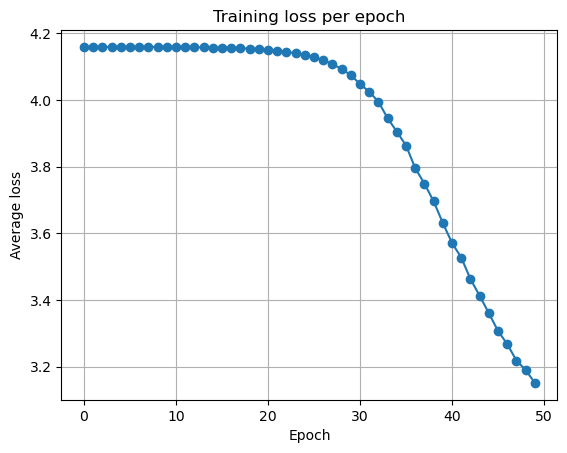

In [16]:
# Block 7 — Plot loss
import matplotlib.pyplot as plt
plt.plot(history['epoch_losses'], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.title('Training loss per epoch')
plt.grid(True)
plt.show()

### Vizualization

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
 

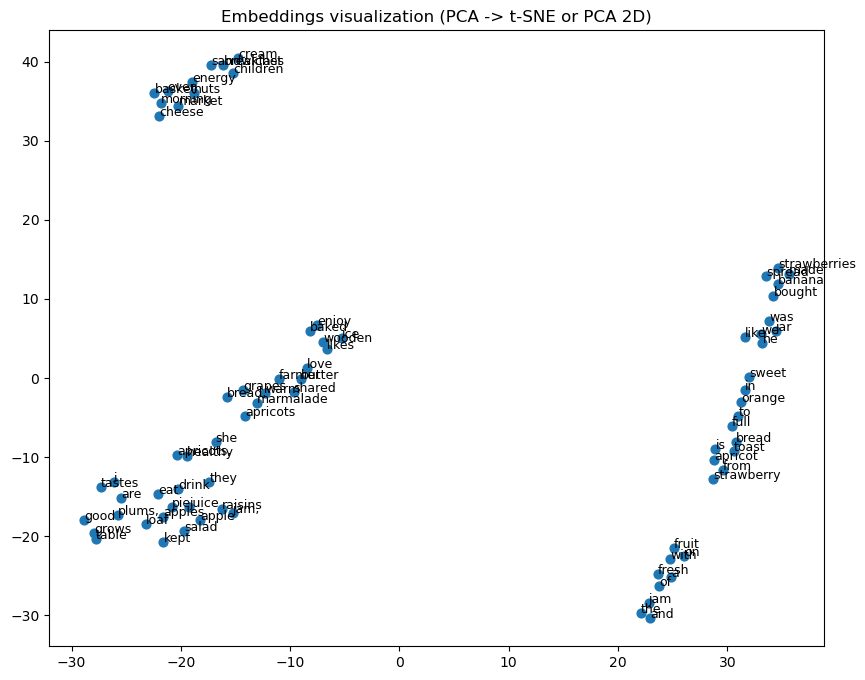

In [17]:
# Robust PCA -> t-SNE visualization (works for small vocabularies)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ensure emb is numpy
if not isinstance(emb, np.ndarray):
    emb_np = emb.cpu().numpy() if hasattr(emb, "cpu") else np.array(emb)
else:
    emb_np = emb

n_samples, n_features = emb_np.shape
# choose PCA components safely
pca_n = min(50, n_features, n_samples)   # can't exceed min(n_samples, n_features)
if pca_n < 2:
    raise ValueError(f"Too few samples/features for PCA: samples={n_samples}, features={n_features}")

# 1) PCA reduce to speed up t-SNE (or to 2D directly if very small)
pca = PCA(n_components=pca_n, random_state=42)
emb_pca = pca.fit_transform(emb_np)

# If vocabulary is very small, you can skip t-SNE and use PCA 2D
if n_samples <= 10:
    # just plot first two PCA components
    emb_2d = emb_pca[:, :2]
else:
    # run t-SNE on PCA-reduced vectors; choose tsne_pca_dim smaller than emb_pca cols
    tsne_pca_dim = min(30, emb_pca.shape[1])   # t-SNE input dim
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, perplexity=5, n_iter=1000, random_state=42, init="pca")
    emb_2d = tsne.fit_transform(emb_pca[:, :tsne_pca_dim])

plt.figure(figsize=(10, 8))
plt.scatter(emb_2d[:,0], emb_2d[:,1], s=40)
for i, word in enumerate(idx2word):
    plt.text(emb_2d[i,0]+0.01, emb_2d[i,1]+0.01, word, fontsize=9)
plt.title("Embeddings visualization (PCA -> t-SNE or PCA 2D)")
plt.show()


### Word Semantics Analysis

#### 1. Find Most Similar Words (Nearest Neighbors)     [0.5M]

In [18]:
# Function to find most similar words (nearest neighbors) for a given word
def most_similar(word, emb, vocab, idx2word, topn=5):
    if word not in vocab:
        return []
    i = vocab[word]                        # index of the given word
    vec = emb[i]                           # embedding vector of the word
    norms = np.linalg.norm(emb, axis=1)    # compute norms of all embeddings
    sims = emb.dot(vec) / (norms * np.linalg.norm(vec))   # cosine similarity
    best = sims.argsort()[::-1]            # sort indices by similarity (descending)
    return [(idx2word[j], float(sims[j])) for j in best[1:topn+1]]

# Test the function
print("Neighbors of 'apricot':", most_similar("apricot", emb, vocab, idx2word))


Neighbors of 'apricot': [('of', 0.9985597133636475), ('a', 0.9982357025146484), ('is', 0.9981145858764648), ('with', 0.9979271292686462), ('the', 0.997885525226593)]


#### 2. Find the Odd Word Out    [0.5]

In [19]:
import numpy as np

def odd_one_out(words, emb, vocab):
    """
    Find the odd word out from a list using embeddings.
    words: list of strings
    emb:   numpy array of shape (V, D) from your model
    vocab: dict mapping word -> index
    """
    # keep only words present in vocab
    valid_words = [w for w in words if w in vocab]
    if len(valid_words) < 2:
        return None
    
    # collect their vectors
    vecs = np.array([emb[vocab[w]] for w in valid_words])
    
    # compute mean vector
    mean_vec = np.mean(vecs, axis=0)      # average of word vectors
    
    # cosine similarity of each word with mean
    sims = [np.dot(v, mean_vec) / (np.linalg.norm(v) * np.linalg.norm(mean_vec)) 
            for v in vecs]
    
    # word with lowest similarity = odd one
    odd_word = valid_words[int(np.argmin(sims))]
    return odd_word

# Test the function
print("Odd one out:", odd_one_out(["apricot", "jam", "strawberry", "toast"], emb, vocab))



Odd one out: apricot


#### 3. Cosine Similarity Between Two Words   [1 M]

In [20]:
import numpy as np

def cosine_similarity(word1, word2, emb, word2idx):
    """
    Compute cosine similarity between two words using raw embeddings.
    Normalizes rows inside the function.
    """
    if word1 not in word2idx or word2 not in word2idx:
        return None
    
    # normalize embeddings row-wise (on the fly)
    norms = np.linalg.norm(emb, axis=1, keepdims=True)
    norms[norms == 0] = 1.0  # avoid division by zero
    norm_emb = emb / norms
    
    # get vectors
    v1 = norm_emb[word2idx[word1]]
    v2 = norm_emb[word2idx[word2]]
    
    # cosine similarity = dot product (since normalized)
    return float(np.dot(v1, v2))

# Test similarity
print("sim(apricot, jam)   =", cosine_similarity("apricot", "jam", emb, vocab))
print("sim(apricot, toast) =", cosine_similarity("apricot", "toast", emb, vocab))


sim(apricot, jam)   = 0.9975764751434326
sim(apricot, toast) = 0.9969043731689453
